In [108]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
#IMPORT NECESSARY PACKAGES
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sklearn
from sklearn import preprocessing

In [109]:
import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)

from CO2_functions import *
from CO2_Processing import *

In [ ]:
#Get the data from CHPC
data_orig = retrieve_data_from_folder('Z:\\CO2_Data')

Enter Start Date YYYY-mm-DD:  2019-09-19
Enter End Date YYYY-mm-DD:  2019-10-03


Retrieving data for 2019-09-19
Retrieving data for 2019-09-20
Retrieving data for 2019-09-21
Retrieving data for 2019-09-22
Retrieving data for 2019-09-23
Retrieving data for 2019-09-24
Retrieving data for 2019-09-25
Retrieving data for 2019-09-26
Retrieving data for 2019-09-27
Retrieving data for 2019-09-28


In [6]:
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
data = combine_vent_data(data) #Combine LI_Vent and Vent_Anem_Temp into a single df
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 

Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero


KeyError: 'wd'

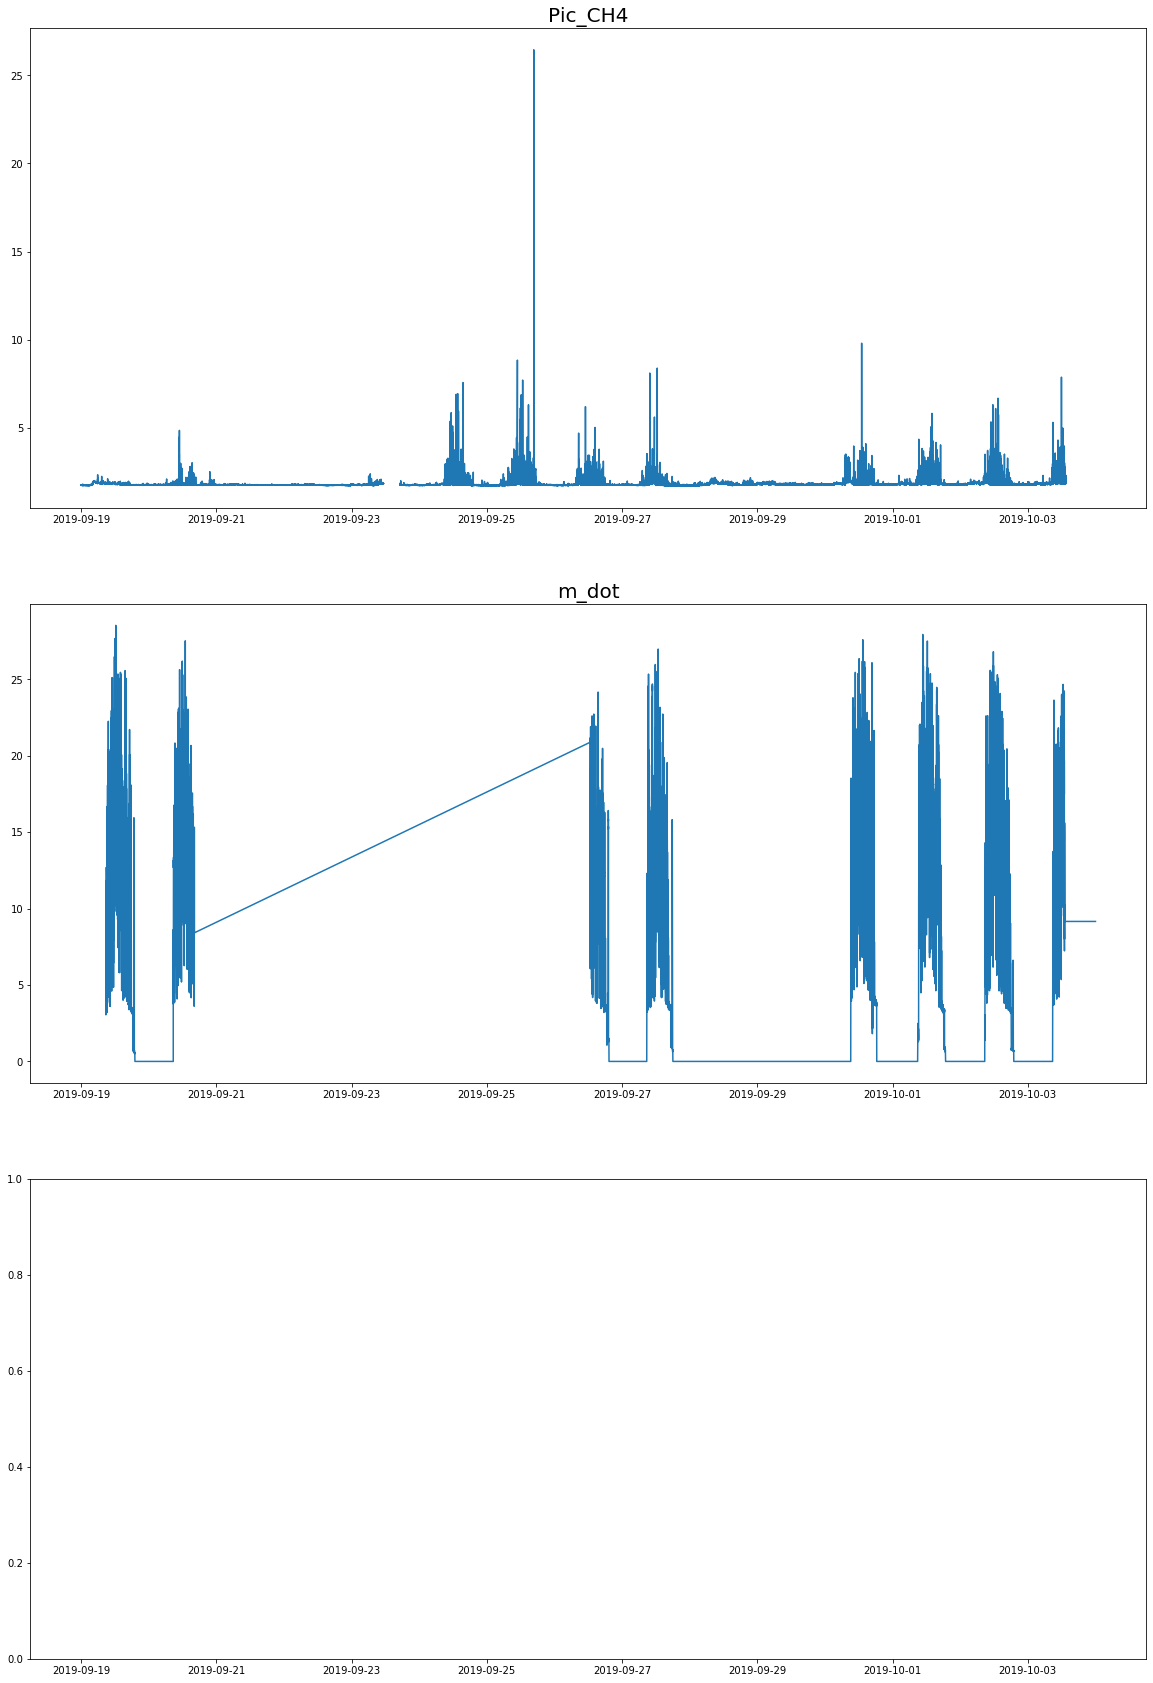

In [102]:
#Clip the picarro and vent_mass data frames to a specific region of interest
pic,vent = plot_refinement_all([[data['Picarro'],'Corrected_DT','Pic_CH4'],\
                                [data['Vent_Mass'].interpolate(),'Corrected_DT','m_dot']],\
                               'separate')

In [76]:
#Apply a moving average and downsample
#Numbers of seconds
vent.drop('DOW',inplace=True,axis=1)

pic_proc = moving_average(pic,10)
vent_proc = moving_average(vent,10)

pic_proc = dwn_sample(pic_proc,10)
vent_proc = dwn_sample(vent_proc,10)

Applying a central moving average of 10 seconds
Applying a central moving average of 10 seconds
Downsampling by mean at 10 seconds
Downsampling by mean at 10 seconds


In [78]:
#Concatenate and add wind speed & direction
df = pd.concat([pic_proc,vent_proc],axis=1)
df = wind_add(df,'ANEM_X','ANEM_Y')

#Drop columns
df.drop(['DOW','Pic_Loc','LI_CO2','Rotations','Velocity','Temp_1','Temp_2','Q','Excess'],axis=1,inplace=True)
df.dropna(inplace=True)

Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'


C:\Users\agmey\Anaconda3\envs\CO2_Eddy\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [86]:
#Make mass flux the last column
loc = df.columns.get_loc('m_dot')

cols = df.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
df = df[cols]



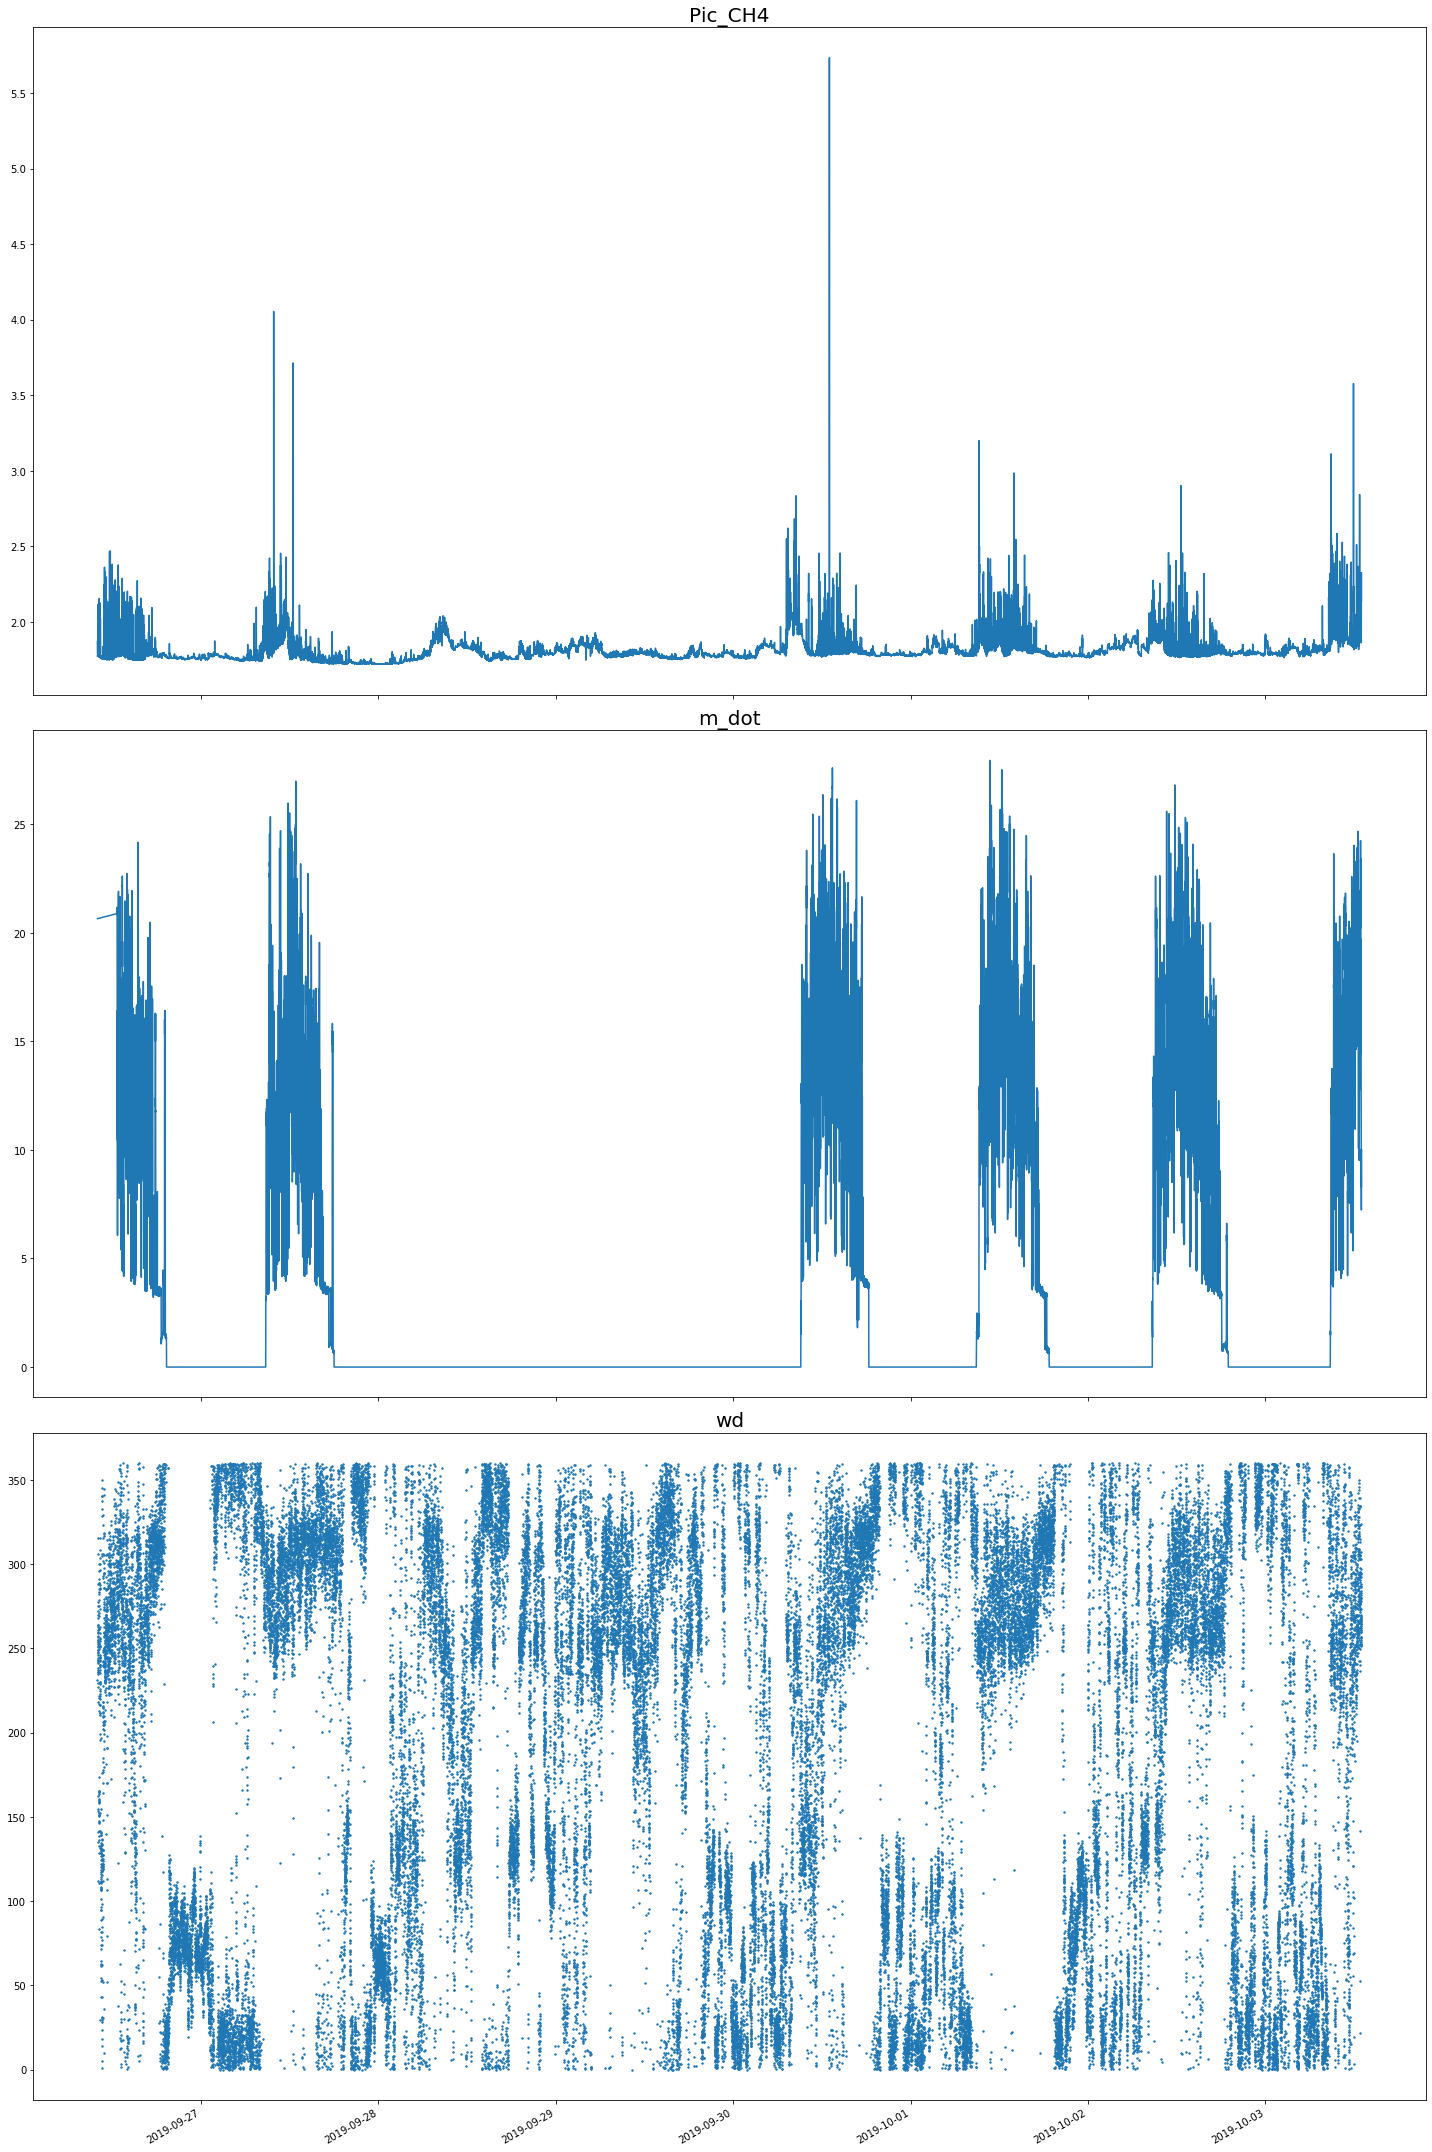

Is this an acceptable range?  2019-09-30 10:00:00
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-30 16:00:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-30 10:00:00


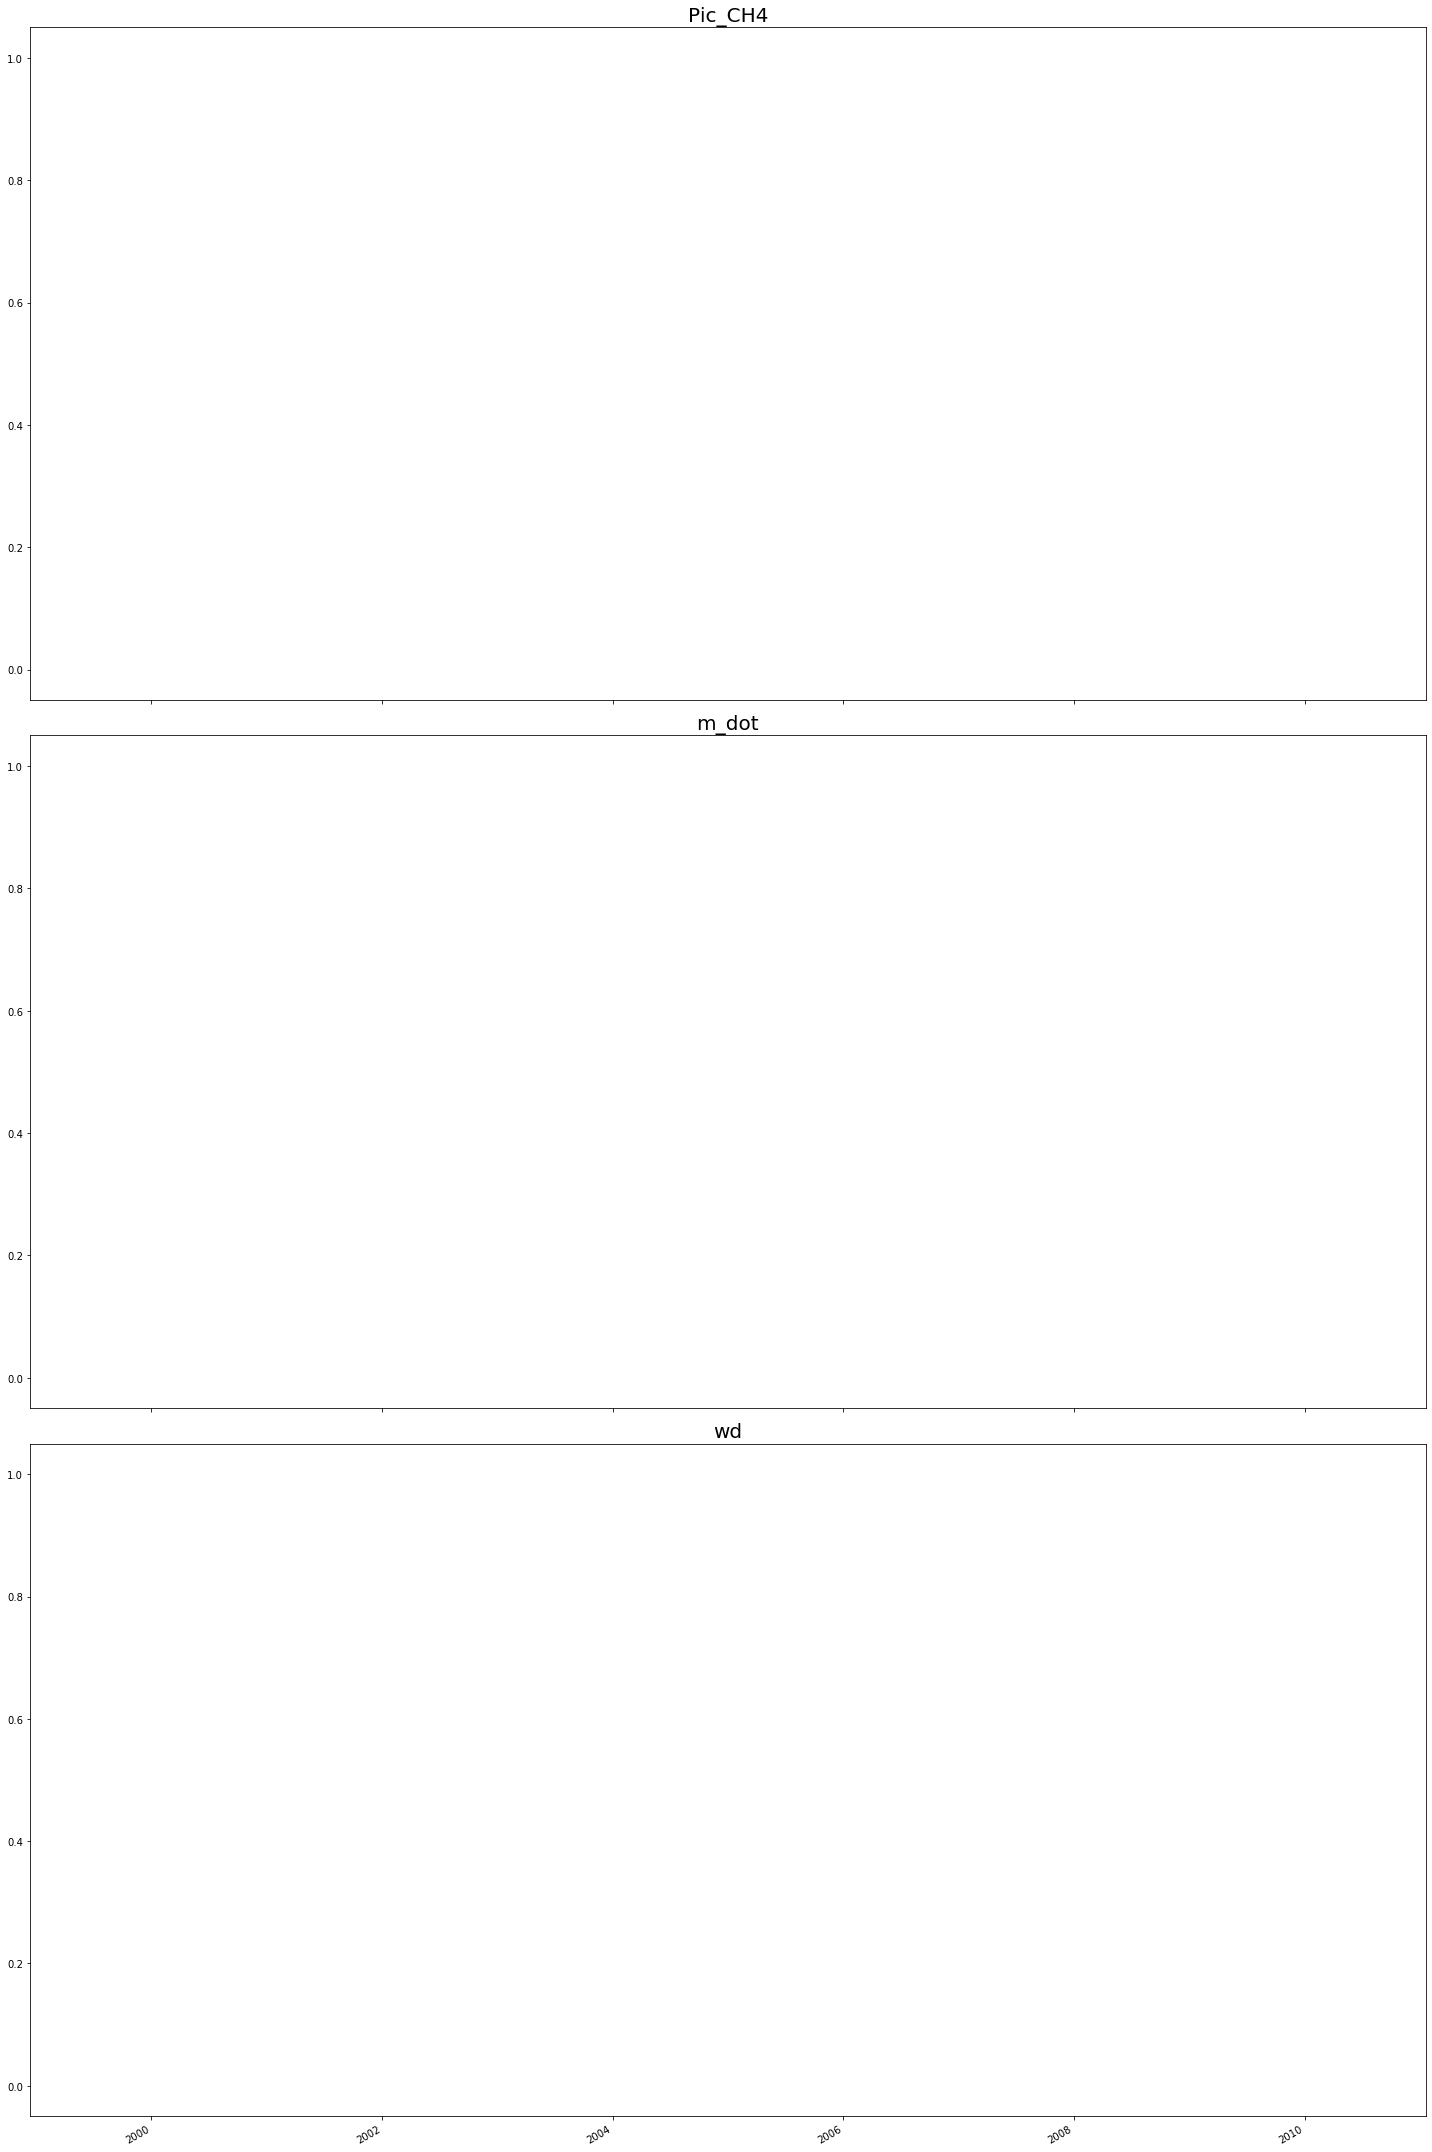

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-30 10:00:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-30 16:00:00


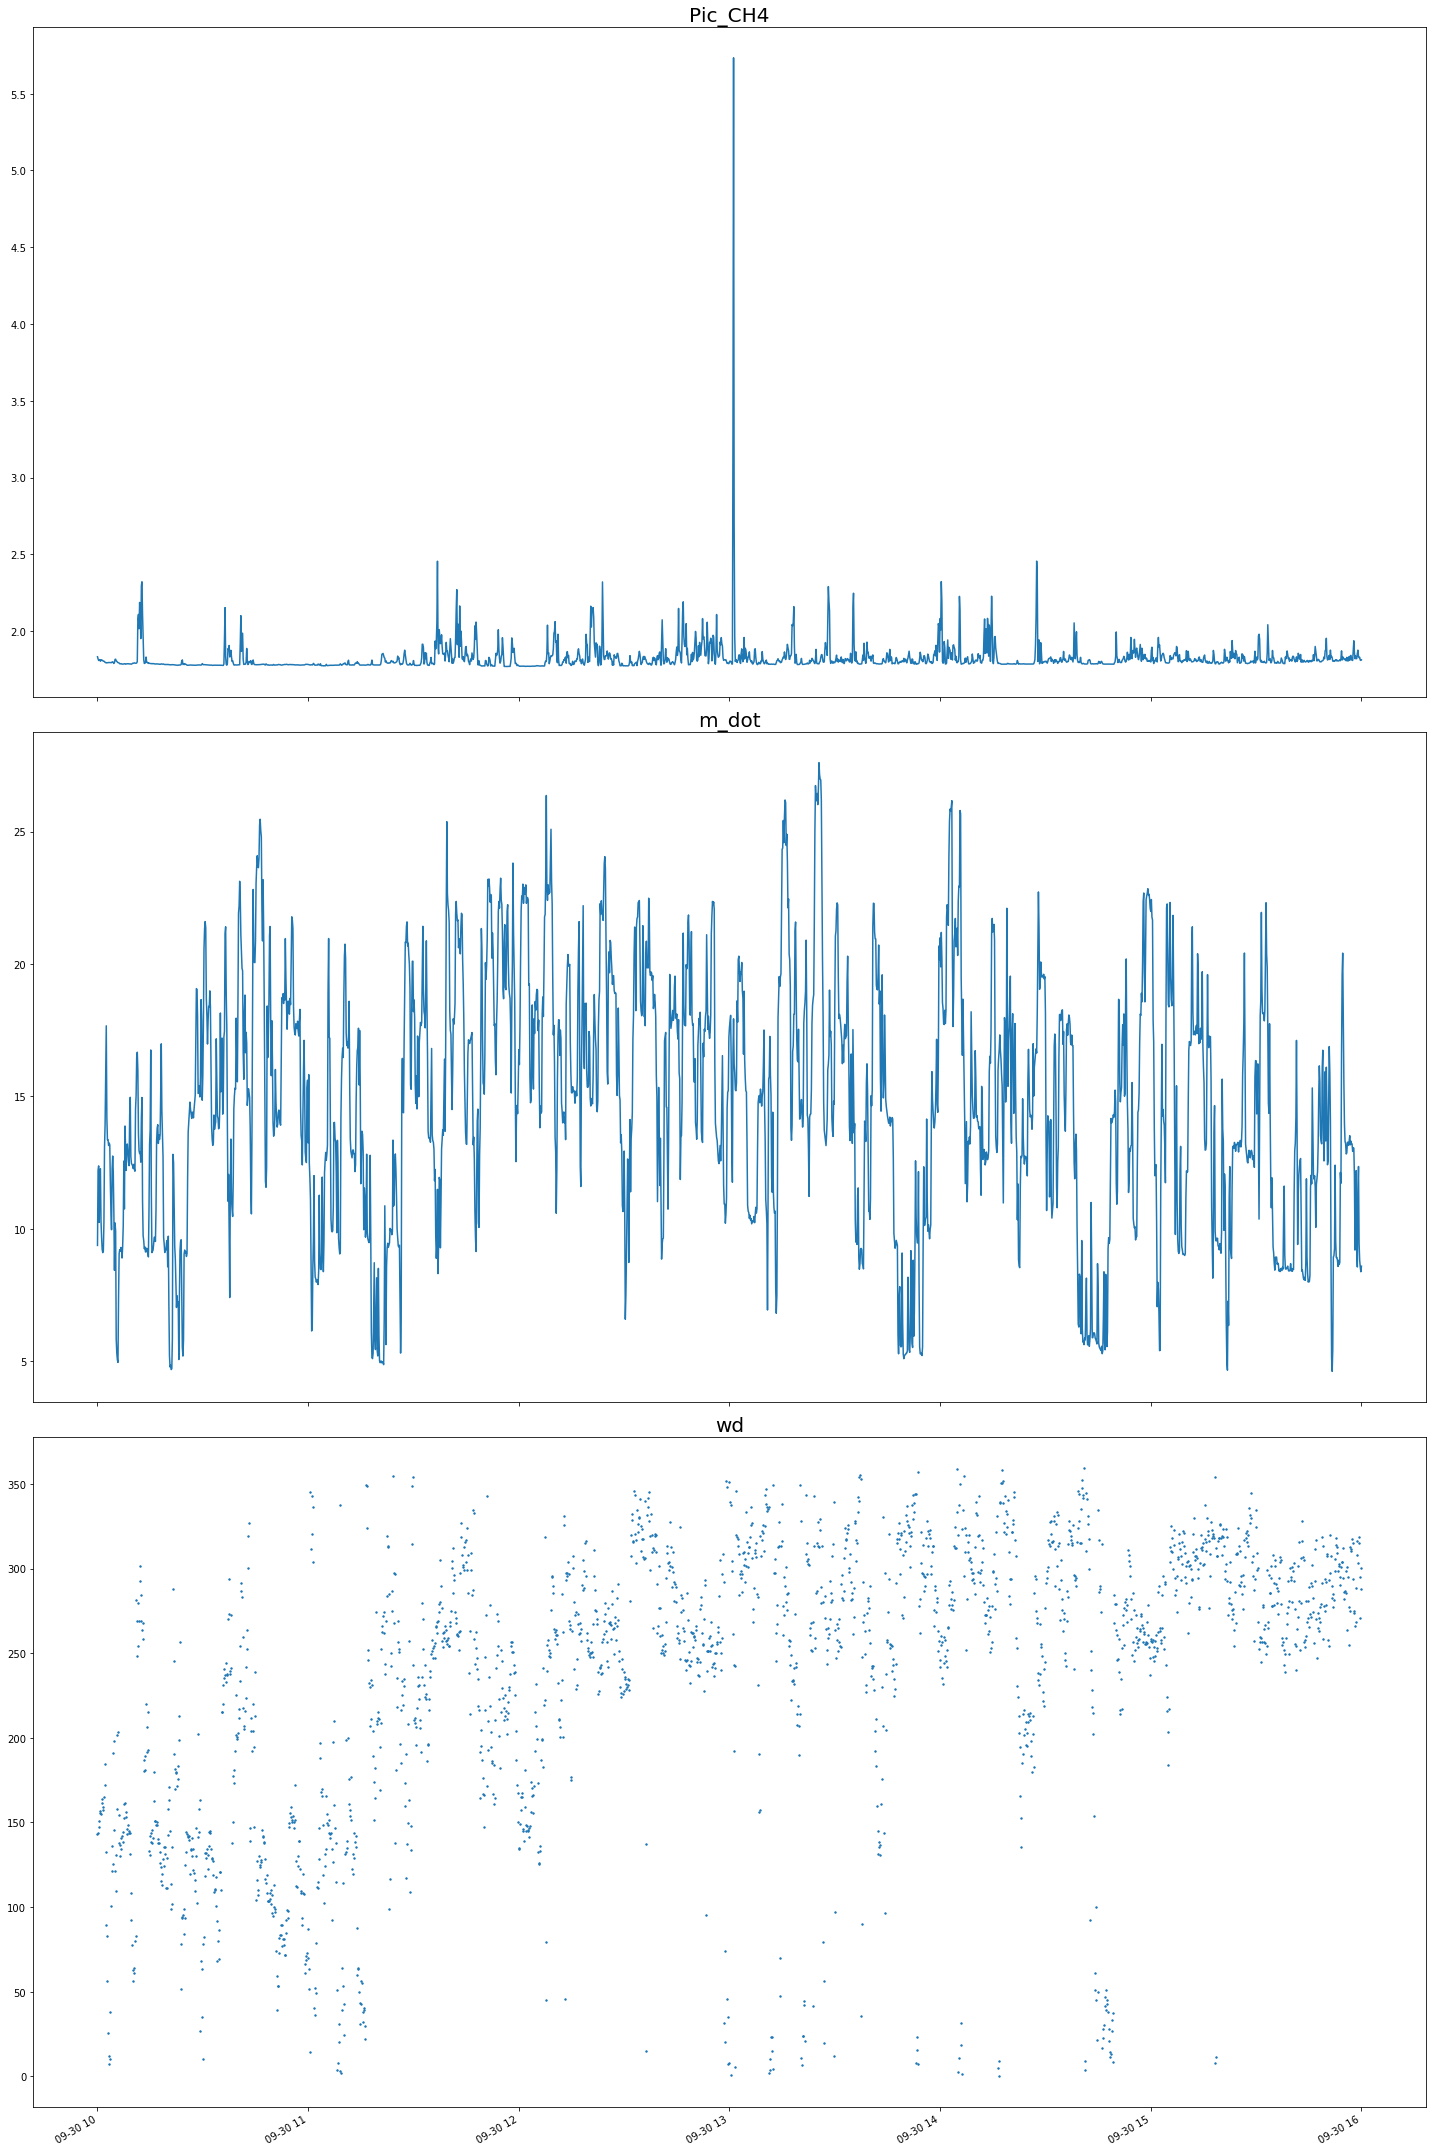

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-30 12:50:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-30 13:15:00


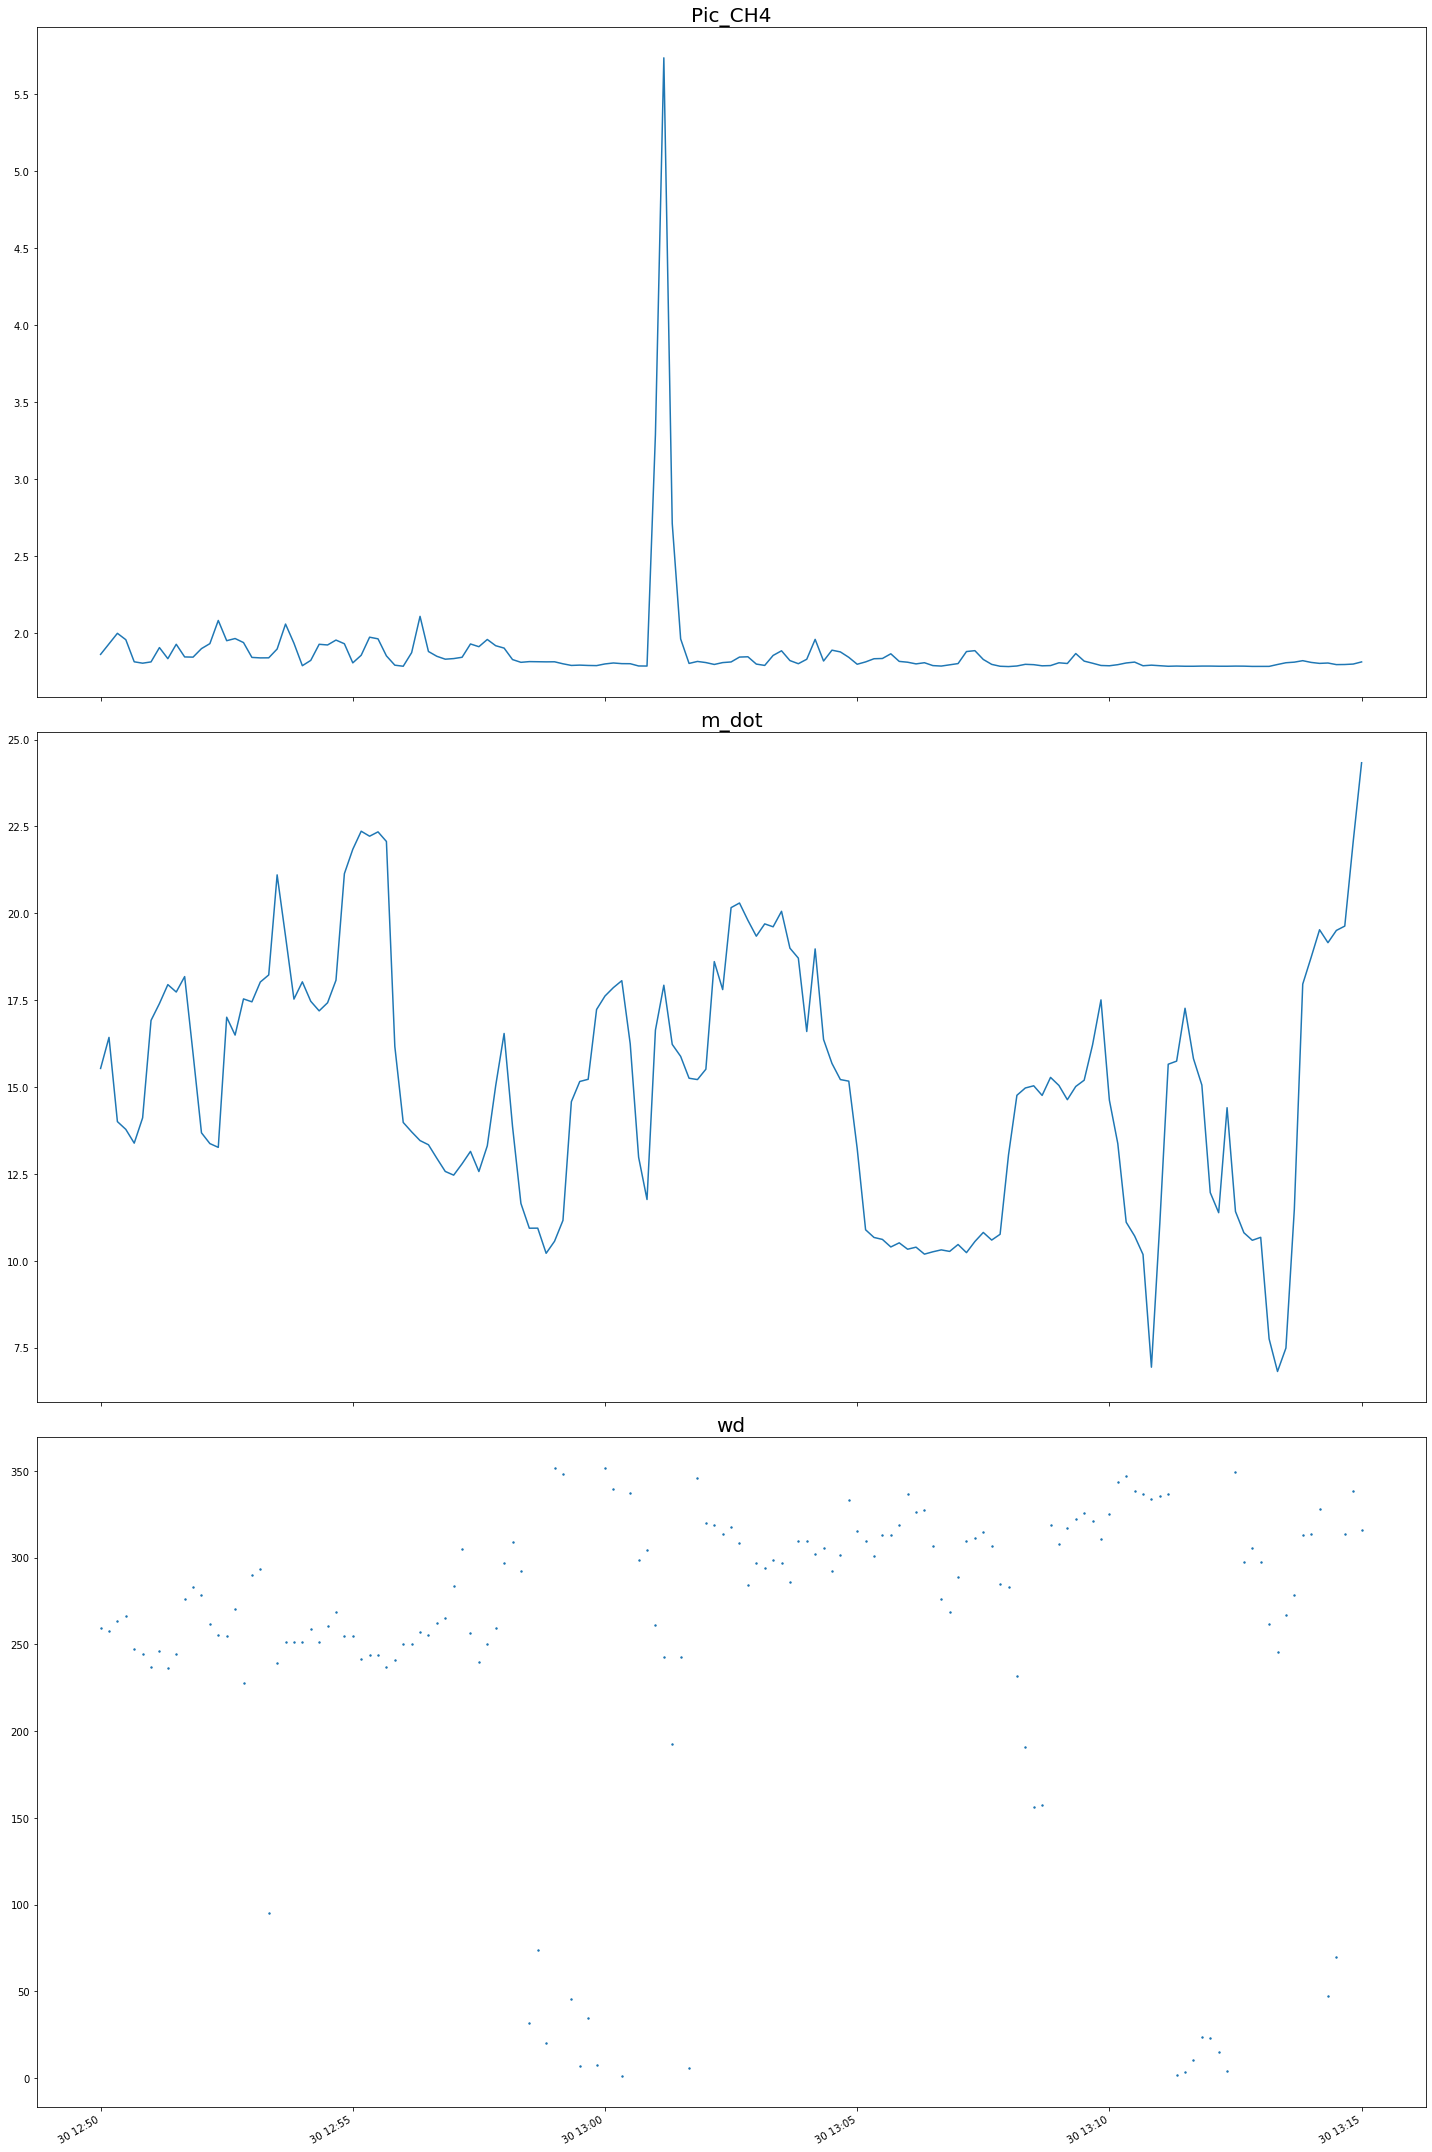

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-30 13:00:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-30 13:05:00


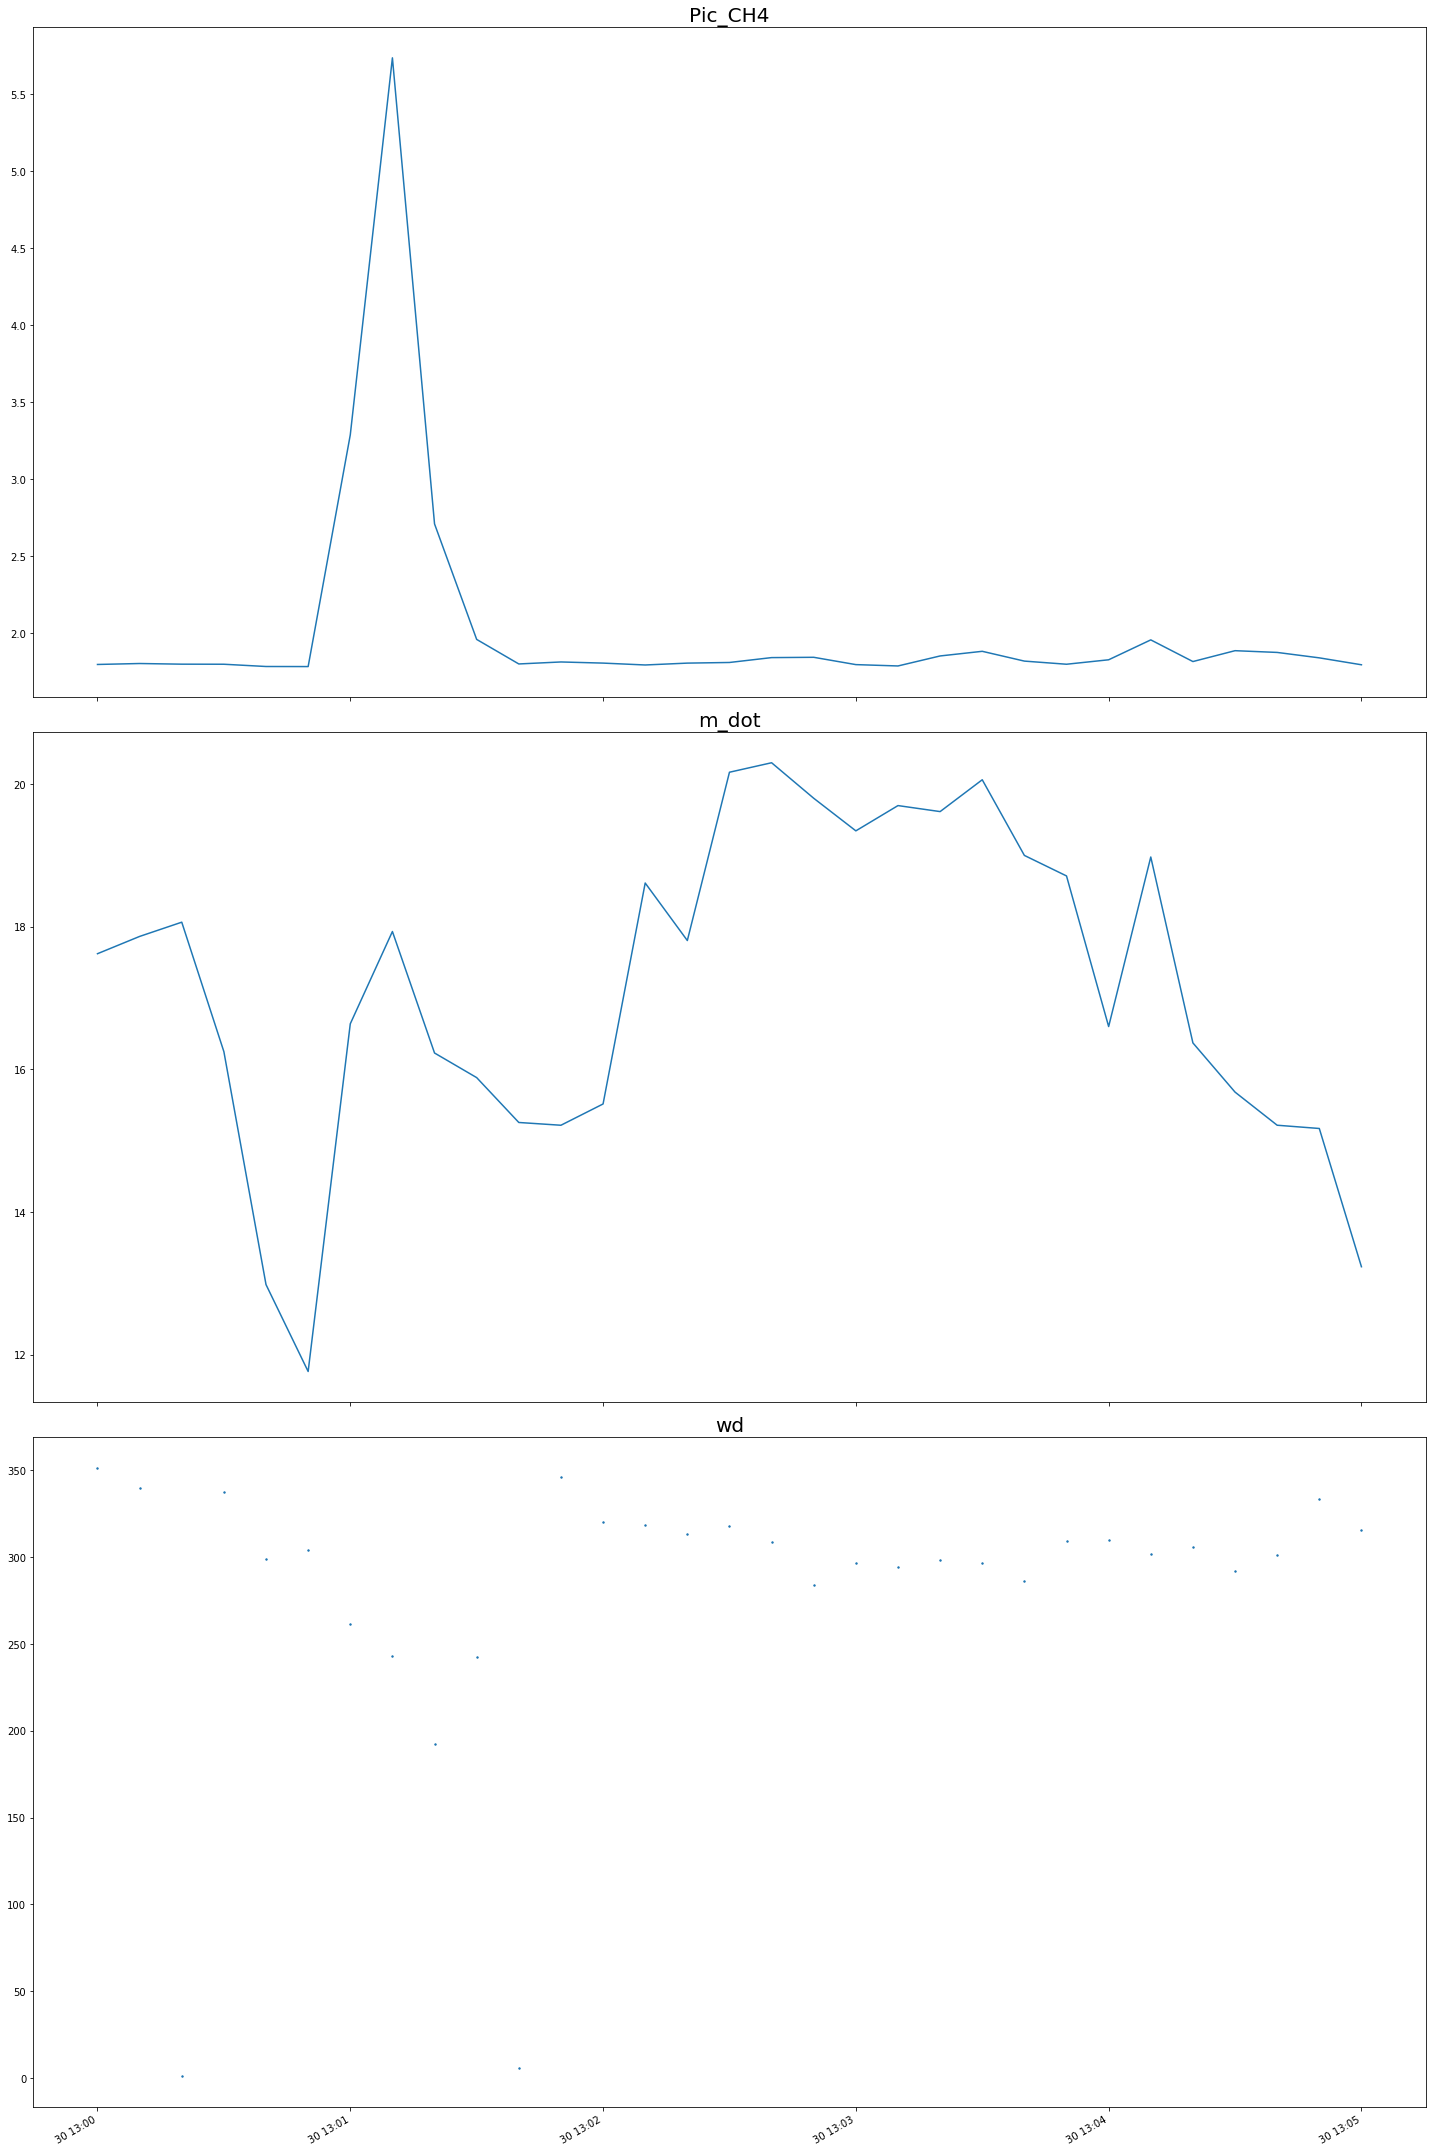

Is this an acceptable range?  y


[             Corrected_DT     Pic_CO2   Pic_CH4    ANEM_Y    ANEM_X    ANEM_Z  \
 35502 2019-09-30 13:00:00  409.721992  1.798589 -1.198882  0.180998  0.037291   
 35503 2019-09-30 13:00:10  410.064820  1.804756 -1.024291  0.383498  0.256061   
 35504 2019-09-30 13:00:20  408.861628  1.800496 -1.038744 -0.017801  0.405304   
 35505 2019-09-30 13:00:30  406.786074  1.800026 -0.727806  0.303811  0.435005   
 35506 2019-09-30 13:00:40  402.994366  1.785388 -0.407456  0.744822  0.030508   
 35507 2019-09-30 13:00:50  402.773557  1.784915 -0.165752  0.243248 -0.194578   
 35508 2019-09-30 13:01:00  409.221157  3.288151  0.053919  0.352765 -0.082767   
 35509 2019-09-30 13:01:10  424.568638  5.733829  0.130282  0.254677  0.313615   
 35510 2019-09-30 13:01:20  424.402485  2.710209  0.351286  0.077539  0.327397   
 35511 2019-09-30 13:01:30  412.132017  1.961055  0.197783  0.380102  0.249985   
 35512 2019-09-30 13:01:40  405.876441  1.801898 -0.282067 -0.028216  0.169138   
 35513 2019-09-3

In [105]:
plot_refinement_all([[df,'Corrected_DT','Pic_CH4'],[df,'Corrected_DT','m_dot'],[df,'Corrected_DT','wd']],'separate')

In [87]:
df1 = df
df1['wd_ct'] = np.zeros(len(df1))
for i in range(1,len(df1)):
    if (df1['wd'][i] > 240) & (df1['wd'][i] < 300):
        df1['wd_ct'][i] = df1['wd_ct'][i-1]+1
    else:
        continue

df2 = df1.loc[df1['wd_ct']>0]
df2.drop('wd_ct',axis=1,inplace=True)

C:\Users\agmey\Anaconda3\envs\CO2_Eddy\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [88]:
#SET UP TIME LAGGING FUNTION
#Courtesy of Jason Brownlee
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [89]:
#We need to delete some of the columns generated by the series_to_supervised function
def delete_unwanted_cols(initial_lagged_df):
    #We want to delete all of the values of LI_CO2 EXCEPT the t=t case (very last one)
    s = "m_dot" 
    drop_cols = [] #initialize columns to be dropped
    for column in initial_lagged_df:
        if s not in column and "(t)" in column:
            drop_cols.append(column)     #Drop all columns except the LI_CO2 column at time t (only want the lagged variables)
        elif s in column and "(t)" not in column:
            drop_cols.append(column)     #Drop all columns with LI_CO2 that arent the last one
    return initial_lagged_df.drop(drop_cols,axis = 1)  

In [93]:
#TIME LAG
n_seconds = 2 #how many periods to lag
n_features= len(df2.columns)-1 #how many features exist in the feature matrix (number of cols - target col)
time_lagged = series_to_supervised(df2,n_in=0,n_out=n_seconds) #lag function
time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns
#pd.set_option("display.max_columns", 9)
cols = list(time_lagged_reframed.columns)
cols = cols[1:] + [cols[0]]
time_lagged_reframed = time_lagged_reframed[cols]
time_lagged_reframed.head()

,Pic_CO2(t+1),Pic_CH4(t+1),ANEM_Y(t+1),ANEM_X(t+1),ANEM_Z(t+1),WBB_CO2(t+1),WBB_CH4(t+1),wd(t+1),ws(t+1),m_dot(t)
Corrected_DT,,,,,,,,,,
2019-09-26 10:00:20,422.787415,1.819639,0.360173,1.133355,-0.031884,427.820,1.95838,252.370076,1.602806,20.653445
2019-09-26 10:00:30,434.480321,1.874502,0.246588,1.120969,0.048265,427.838,1.95914,257.593784,1.585289,20.653692
2019-09-26 10:00:40,427.182540,1.815580,0.304711,1.135292,0.051686,427.735,1.95910,254.975989,1.605546,20.653938
2019-09-26 10:00:50,425.804902,1.819636,0.177214,0.971666,0.013245,427.592,1.95856,259.663905,1.374143,20.654185
2019-09-26 10:01:00,431.584949,1.862493,0.158196,0.998139,0.185344,427.398,1.95896,260.994075,1.411582,20.654432


In [95]:
values = time_lagged_reframed.dropna().values #Convert to numpy for processing
min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1

In [96]:
#Set train size. Because time is a factor, we do not choose randomly, but chronologically
percent_train = 0.75
train_size = int(len(df2)*percent_train) 

In [97]:
train = values_scaled[:train_size,:]  #Get train/test arrays
test = values_scaled[train_size:,:]

In [98]:
X_train,y_train = train[:,:-1], train[:,-1] #Get feature/target arrays
X_test, y_test = test[:,:-1], test[:,-1]

In [99]:
#X_train = X_train.reshape((X_train.shape[0], 1, 9)) 
#X_test = X_test.reshape((X_test.shape[0], 1, 9))
X_train = X_train.reshape((X_train.shape[0], n_seconds-1, n_features)) 
X_test = X_test.reshape((X_test.shape[0], n_seconds-1, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11812, 1, 9) (11812,) (3937, 1, 9) (3937,)


In [100]:
model = Sequential()
model.add(LSTM(128,input_shape=(X_train.shape[1:]),activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
model.fit(X_train,y_train,epochs=3,validation_data=(X_test,y_test))

Train on 11812 samples, validate on 3937 samples
Epoch 1/3
11812/11812 [==============================] - 10s 863us/sample - loss: 0.0664 - accuracy: 0.5077 - val_loss: 0.0547 - val_accuracy: 0.1961
Epoch 2/3
11812/11812 [==============================] - 4s 316us/sample - loss: 0.0510 - accuracy: 0.5070 - val_loss: 0.0535 - val_accuracy: 0.1956
Epoch 3/3
11812/11812 [==============================] - 4s 327us/sample - loss: 0.0482 - accuracy: 0.5073 - val_loss: 0.0607 - val_accuracy: 0.1943


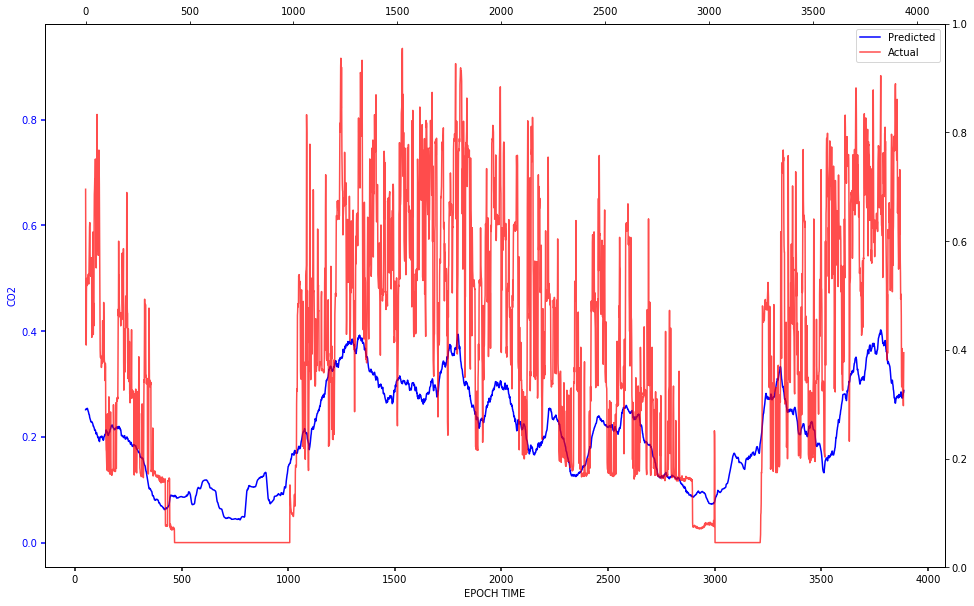

In [107]:
#PLOT PREDICTED VS OBSERVED
yfit = model.predict(X_test)
yfit = pd.DataFrame(yfit)
yfit_roll = yfit.rolling(100,center=True).mean()

fig, host = plt.subplots(figsize = (20,10))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par1 = host.twiny()


p1, = host.plot(yfit_roll, "b-", label="Predicted")
p2, = par1.plot(y_test, "r-", alpha = 0.7,label="Actual")

host.set_xlabel("EPOCH TIME")
host.set_ylabel("CO2")
par1.set_ylabel("CO2")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines])

plt.show()